In [48]:
import numpy as np
import pandas as pd
import random

import torch
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from skimage.transform import resize
from sklearn.metrics import roc_auc_score
import albumentations as A

from pathlib import Path
# import SimpleITK as sitk
# import pydicom
import os,sys
import matplotlib.pyplot as plt
# import cv2

In [2]:
# Figure out whether we have a GPU; if not use the CPU
device = torch.device('cuda:5' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=5)

In [19]:
meta = pd.read_csv('../zhout/Documents/mask_vol_all.csv')

/tmp/ipykernel_46173/2436864148.py:1: DtypeWarning: Columns (9,27,45,59,60,61,76,93,94,98,101,108,112,113,120) have mixed types. Specify dtype option on import or set low_memory=False.
  meta = pd.read_csv('../zhout/Documents/mask_vol_all.csv')


In [20]:
meta['file_path'] = meta['PiCare PatientID'] + '_'+ meta['StudyDateAnon'].str.replace('-','') 
meta = meta.query('mask_volume>1000').reset_index(drop=True)
subset = meta.sample(n=50, random_state=29).reset_index(drop=True)
subset['PiCare PatientID'].nunique() # each patient has one roi

49

In [17]:
meta.shape

(1223, 125)

In [37]:
meta['Failure-binary'].value_counts()

0    1000
1     223
Name: Failure-binary, dtype: int64

### Dataset

In [7]:
#!pip install -U albumentations

In [22]:
from albumentations.pytorch import ToTensorV2
import cv2

In [23]:
image_path = meta['image_path']
mask_path = meta['mask_path']

In [24]:
idx = 0
image_array = np.load(image_path[idx])
mask_array = np.load(mask_path[idx])

In [11]:
# cv_img = cv2.imwrite('img',image_array)

In [27]:
transforms = A.Compose([
                # spatial transforms
                A.RandomCrop(width=256, height=256),
                A.HorizontalFlip(p=.5),
                A.VerticalFlip(p=.5),
                A.Rotate(limit = 10, 
                        value = 0.0, p = .5),
            ])

In [28]:
img_array = resize(image_array,(64,256,256))
msk_array = resize(mask_array,(64,256,256))
stack_image = np.stack([img_array,msk_array]).transpose()

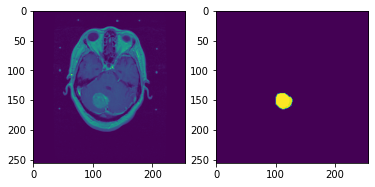

In [29]:
slice_idx = 18

plt.subplot(1,2,1)
plt.imshow(img_array[slice_idx])

plt.subplot(1,2,2)
plt.imshow(msk_array[slice_idx])

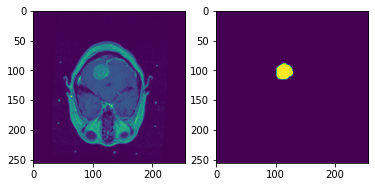

In [30]:
trasimg = transforms(image = img_array.transpose(),mask = msk_array.transpose())
# print(trans_img)
# tranim = a.transpose()
plt.subplot(1,2,1)
plt.imshow(trasimg['image'].transpose()[slice_idx])

plt.subplot(1,2,2)
plt.imshow(trasimg['mask'].transpose()[slice_idx])

In [31]:
import math
def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

# random crop to the original size
def random_crop(x, r_pix=4):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=3):
    r, c,*_ = x.shape
    print (x.shape == (56,704,704),x.shape)
    c_pix = round(r_pix*c/r)
    print(r_pix*c, r, c_pix)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)


# def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
#     """ Rotates an image by deg degrees"""
#     r,c,*_ = im.shape
#     M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
#     return cv2.warpAffine(im,M,(c,r), borderMode=mode, 
#                           flags=cv2.WARP_FILL_OUTLIERS+interpolation)

In [32]:
class BrainMetDataset(Dataset):
    def __init__(self, image_path, mask_path, labels, transform = True, img_size = (64,256,256)):
        self.image_path = image_path
        self.mask_path = mask_path
        self.labels = labels
        self.img_size = img_size
        if transform == True:
            self.transformation = A.Compose([
                # spatial transforms
                A.RandomCrop(width=256, height=256),
                A.HorizontalFlip(p=.5),
                A.VerticalFlip(p=.5),
                A.Rotate(limit = 10, 
                        value = 0.0, p = .5)])
        else:
            self.transformation = A.Compose([])
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self,index):
        y = self.labels[index]
        img_array = np.load(self.image_path[index])
        msk_array = np.load(self.mask_path[index])
            

        img_array = resize(img_array,self.img_size).transpose()
        msk_array = resize(msk_array,self.img_size).transpose()
        
        trans = self.transformation(image = img_array,mask = msk_array)
        trans_img = trans['image'].transpose()
        trans_msk = trans['mask'].transpose()
        ### output should be torch tensor
        return torch.tensor([trans_img,trans_msk],dtype=torch.double), torch.tensor(y,dtype=torch.double)

In [33]:
def get_train_valid(subset):
    np.random.seed(5)
    msk = np.random.rand(len(subset))<0.8
    train = subset[msk].reset_index()
    valid = subset[~msk].reset_index()
    return train,valid

train,valid = get_train_valid(meta)
# train,valid = get_train_valid(subset)


In [34]:
train_ds = BrainMetDataset(train['image_path'],train['mask_path'],train['Failure-binary'])
valid_ds = BrainMetDataset(valid['image_path'],valid['mask_path'],valid['Failure-binary'])


In [35]:
train_dl = DataLoader(train_ds,batch_size=3,shuffle=True)
valid_dl = DataLoader(valid_ds,batch_size=3,shuffle=False)

In [38]:
%%time
a = next(iter(train_dl))

CPU times: user 6.4 s, sys: 1.67 s, total: 8.07 s
Wall time: 6.88 s


In [39]:
x,y = a
x.shape,y

(torch.Size([3, 2, 64, 256, 256]), tensor([0., 0., 0.], dtype=torch.float64))

## CNN/UNET Model

In [40]:
# https://pytorch.org/docs/stable/generated/torch.nn.Conv3d.html

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv3d( 
                in_channels = 2,  # Based on twolayer, in_dim = 2*50*256*256 
                out_channels = 32,            
                kernel_size = 1,             
                stride = 1,                   
                padding=0),               
            nn.ReLU(),                    
            nn.MaxPool3d(kernel_size = 1, 
                         stride = 1))     
        self.fc1 = nn.Linear(in_features = 32*50*256*256,
                             out_features = 1)
        
    def calculate_size(shape, kernel, stride = 1, padding = 0):
        return [(s - kernel +2*padding)//stride +1 for s in shape]
    
    def forward(self, x):
#         print(x.shape)
        outs = None
        x = self.conv(x)
#         print(x.shape)
        x = x.view(x.size(0), -1)
        outs = self.fc1(x)

        return outs
    

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv3d(in_channels, out_channels, f_size, padding=(pad,pad,pad))
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.conv2 = nn.Conv3d(out_channels, out_channels, f_size, padding=(pad,pad,pad))
        self.bn2 = nn.BatchNorm3d(out_channels)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x
    
class unet(nn.Module):
    
    def __init__(self,h= 50):
        
        super().__init__()
        
        # pooling
        self.pool = nn.MaxPool3d(2,2)
        
        # ENCODER

        # block 00 (down)
        #self.conv00 = ConvBlock(1+len(masks), channels[0])
        self.conv00 = ConvBlock(input_channels, channels[0])
        # block 10 (down)
        self.conv10 = ConvBlock(channels[0], channels[1])
        # block 20 (down)
        self.conv20 = ConvBlock(channels[1],channels[2])

        
        # DECODER
        
        # block 22 (up)
        self.upconv22 = nn.ConvTranspose3d(channels[2],channels[1],2,stride=2)
        self.conv22 = ConvBlock(2*channels[1],channels[1])
        # block 13 (up)
        self.upconv13 = nn.ConvTranspose3d(channels[1],channels[0],2,stride=2)
        self.conv13 = ConvBlock(2*channels[0],channels[0])

        
        # final layers
        self.final04 = nn.Conv3d(channels[0],1,1)
        self.linear1 = nn.Linear(in_features = 1*64*256*256,out_features=h)
        self.linear2 = nn.Linear(in_features = h,out_features=1)
        self.relu = nn.ReLU()
    
    def get_dimension(shape):
        d = 1
        for i in shape[1:]:
            d *= i
        return d
    
    def forward(self, x):
        
        # Encoder Path
        x00 = self.conv00(x)
        x10 = self.conv10(self.pool(x00))
        x = self.conv20(self.pool(x10))

        # Up-sampling second round
        x = self.upconv22(x)
        x = self.conv22(torch.cat((x10,x),dim=1))
        del x10

        # Up-sampling third round
        x = self.upconv13(x)

        x = self.conv13(torch.cat((x00,x),dim=1))
        del x00
        

        
        # Outputs
        x = self.final04(x)

        x = x.view(x.size(0), -1)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        
        return x

In [49]:
def train_loop(model,train_dl,valid_dl, optimizer, epochs, loss_best = 1):
    for i in tqdm(range(epochs)): ## going through all your training data once
        model.train()
        losses = []
        for x, y in train_dl:
            y = y.unsqueeze(1)
            x = x.to(device)
            y = y.to(device)
            y_hat = model(x.float())
            loss = F.binary_cross_entropy_with_logits(y_hat, y.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())## loss is a tensor of one number, if we call item(), we just keep the number
        
        model.eval()
        train_loss = np.mean(losses)
        valid_loss, valid_acc, valid_auc = val_metric(model, valid_dl)
        print("train loss %.4f valid loss %.4f valid AUC %.4f valid ACC %.4f" % 
              (train_loss, valid_loss, valid_auc,valid_acc))
        if valid_loss < loss_best:
#             now = datetime.now()
#             dt_string = now.strftime("%d/%m/%Y-%H:%M:%S")
            torch.save(model.state_dict(), 'm4.pt')
            loss_best = valid_loss
    return loss_best

In [42]:
def val_metric(model, valid_dl):
    model.eval()
    losses = []
    y_preds = []
    ys = []
    for x, y in valid_dl:  
        y = y.unsqueeze(1)
        x = x.to(device)
        y = y.to(device)
        
        y_hat = model(x.float())
        loss = F.binary_cross_entropy_with_logits(y_hat, y.float())
        y = y.cpu()
        y_pred = torch.sigmoid(y_hat).cpu()
        y_preds.append(y_pred.detach().numpy())
        ys.extend(y.detach().numpy()) 
        losses.append(loss.item())
#    print(ys)
    ys = np.concatenate(ys)
    y_hats = np.concatenate(y_preds)
    y_preds_ = np.array([1. if y >=0.5 else 0. for y in y_hats])
    correct = (ys == y_preds_).sum()
    val_acc = correct/len(ys)     
#    print(ys,y_preds_,correct)
    return np.mean(losses), val_acc,roc_auc_score(ys,y_hats)

In [43]:
%%time

try:
    del model
    # del x,y
    del optimizer
    torch.cuda.empty_cache()
except:
    pass

channels = [2, 4, 8, 16]
input_channels = 2
f_size = 3
pad = int((f_size-1)/2)


# model = CNN().to(device)
model = unet().to(device)
best = 1

CPU times: user 8.15 s, sys: 2.67 s, total: 10.8 s
Wall time: 8.5 s


In [46]:
learning_rate = 0.01
wd = 1e-4

def update_learning_rate(optimizer, lr):
    for g in optimizer.param_groups:
        g['lr'] = lr

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay= wd)

In [51]:
%%time
print(best) 
best = train_loop(model,train_dl,valid_dl,optimizer,epochs = 1,loss_best=best)
print(best)
#m3.pt

1


  0%|                                                   | 0/1 [00:00<?, ?it/s]

train loss 305.7957 valid loss 0.4992 valid AUC 0.5000 valid ACC 0.8033


100%|███████████████████████████████████████| 1/1 [1:09:16<00:00, 4156.14s/it]

0.49921973086893556
CPU times: user 1h 34min 8s, sys: 24min 3s, total: 1h 58min 11s
Wall time: 1h 9min 16s


In [52]:
%%time
print(best) 
best = train_loop(model,train_dl,valid_dl,optimizer,epochs = 5,loss_best=best)
print(best)
#m3.pt

0.49921973086893556


  0%|                                                   | 0/5 [00:00<?, ?it/s]

train loss 0.4731 valid loss 0.4946 valid AUC 0.5000 valid ACC 0.8033


 40%|██████████████▊                      | 2/5 [2:09:53<3:14:49, 3896.43s/it]

train loss 0.4707 valid loss 0.4957 valid AUC 0.5000 valid ACC 0.8033


 60%|██████████████████████▏              | 3/5 [3:14:34<2:09:38, 3889.33s/it]

train loss 0.4704 valid loss 0.4947 valid AUC 0.5000 valid ACC 0.8033


 80%|█████████████████████████████▌       | 4/5 [4:19:25<1:04:50, 3890.03s/it]

train loss 0.4705 valid loss 0.4958 valid AUC 0.5000 valid ACC 0.8033


100%|███████████████████████████████████████| 5/5 [5:24:06<00:00, 3889.35s/it]

train loss 0.4707 valid loss 0.4955 valid AUC 0.5000 valid ACC 0.8033
0.4945721298456192
CPU times: user 7h 41min 55s, sys: 1h 51min 19s, total: 9h 33min 15s
Wall time: 5h 24min 6s


In [53]:
%%time
def update_learning_rate(optimizer, lr):
    for g in optimizer.param_groups:
        g['lr'] = lr

print(best) 
update_learning_rate(optimizer, 0.001)
best = train_loop(model,train_dl,valid_dl,optimizer,epochs = 5,loss_best=best)
print(best)

0.4945721298456192


 20%|███████▍                             | 1/5 [1:04:56<4:19:44, 3896.18s/it]

train loss 0.4697 valid loss 0.4955 valid AUC 0.5000 valid ACC 0.8033


 40%|██████████████▊                      | 2/5 [2:09:29<3:14:08, 3882.98s/it]

train loss 0.4698 valid loss 0.4954 valid AUC 0.5000 valid ACC 0.8033


 60%|██████████████████████▏              | 3/5 [3:14:18<2:09:31, 3885.64s/it]

train loss 0.4697 valid loss 0.4955 valid AUC 0.5000 valid ACC 0.8033


 80%|█████████████████████████████▌       | 4/5 [4:19:20<1:04:51, 3891.92s/it]

train loss 0.4698 valid loss 0.4955 valid AUC 0.5000 valid ACC 0.8033


100%|███████████████████████████████████████| 5/5 [5:24:11<00:00, 3890.36s/it]

train loss 0.4698 valid loss 0.4955 valid AUC 0.5000 valid ACC 0.8033
0.4945721298456192
CPU times: user 7h 42min 7s, sys: 1h 53min 30s, total: 9h 35min 37s
Wall time: 5h 24min 11s


In [ ]:
%%time
print(best) 
best = train_loop(model,train_dl,valid_dl,optimizer,epochs = 5,loss_best=best)
print(best)
#m3.pt

0.4945721298456192


 20%|███████▍                             | 1/5 [1:04:45<4:19:02, 3885.70s/it]

train loss 0.4696 valid loss 0.4956 valid AUC 0.5000 valid ACC 0.8033


 40%|██████████████▊                      | 2/5 [2:10:13<3:15:31, 3910.53s/it]

train loss 0.4698 valid loss 0.4955 valid AUC 0.5000 valid ACC 0.8033


 60%|██████████████████████▏              | 3/5 [3:14:58<2:09:57, 3898.73s/it]

train loss 0.4713 valid loss 0.4955 valid AUC 0.5000 valid ACC 0.8033


In [ ]:
print(val_metric(model, valid_dl))

In [ ]:
%%time
#m3.pt
print(best) 
best = train_loop(model,train_dl,valid_dl,optimizer,epochs = 5,loss_best=best)
print(best)

0.46600527447812695


In [ ]:
%%time
#m3.pt
print(best) 
best = train_loop(model,train_dl,valid_dl,optimizer,epochs = 5,loss_best=best)
print(best)